In [7]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer

import xgboost as xgb
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv('04-data/preprocessed_app_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22010 entries, 0 to 22009
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   title                     22010 non-null  object 
 1   description               22010 non-null  object 
 2   summary                   22009 non-null  object 
 3   installs                  22010 non-null  object 
 4   minInstalls               22010 non-null  float64
 5   score                     22010 non-null  float64
 6   ratings                   22010 non-null  float64
 7   reviews                   22010 non-null  float64
 8   histogram                 22010 non-null  object 
 9   price                     22010 non-null  float64
 10  free                      22010 non-null  int64  
 11  currency                  22010 non-null  object 
 12  sale                      22010 non-null  bool   
 13  offersIAP                 22010 non-null  bool   
 14  inAppP

In [9]:
df_sentiment = pd.read_csv('04-data/sentiment_topics_apps.csv')

In [10]:
df= pd.merge(
    df,
    df_sentiment,
    how="inner",
    on='appId',
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

In [85]:
df.columns

Index(['title', 'description', 'summary', 'installs', 'minInstalls', 'score',
       'ratings', 'reviews', 'histogram', 'price', 'free', 'currency', 'sale',
       'offersIAP', 'inAppProductPrice', 'size', 'androidVersion',
       'androidVersionText', 'developer', 'developerId', 'privacyPolicy',
       'developerInternalID', 'genre', 'genreId', 'icon', 'headerImage',
       'screenshots', 'video', 'videoImage', 'contentRating',
       'contentRatingDescription', 'adSupported', 'containsAds', 'released',
       'updated', 'version', 'recentChanges', 'comments', 'editorsChoice',
       'appId', 'url', 'year', 'updated_year', 'description_clean',
       'hist_clean', 'star_1', 'star_2', 'star_3', 'star_4', 'star_5',
       'top_developer', 'current_date', 'days', 'installs_day', 'updated_days',
       'has_video', 'Unnamed: 0', 'app_ads', 'compatibility', 'updates',
       'features', 'bugs', 'payments', 'use_support', 'compound'],
      dtype='object')

In [11]:
df = df[df['genre'] != 'Events']

In [12]:
X = df[['ratings','free','containsAds','genre','editorsChoice','contentRating','year','top_developer',
        'installs_day','updated_days','has_video','compound']]

y = df['score']

In [13]:
# Split to create temporary tr and test 
X_tr, X_test, y_tr, y_test = train_test_split(X, y,test_size=.20, random_state=16)

In [14]:
X_tr_cont = X_tr[['ratings','free','containsAds','editorsChoice','top_developer',
        'installs_day','updated_days','has_video','compound','year']]

In [15]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(X_tr[['genre','contentRating']])

ohe_x_tr = ohe.transform(X_tr[['genre','contentRating']])

columns = ohe.get_feature_names(['genre','contentRating'])

ohe_x_tr_df = pd.DataFrame(ohe_x_tr, columns=columns, index=X_tr.index)

In [16]:
combo_train_df = pd.concat([X_tr_cont, ohe_x_tr_df], axis=1)

In [17]:
# Further split temporary tr to create train and val
X_train, X_val, y_train, y_val = train_test_split(combo_train_df, y_tr,test_size=.20, random_state=10)

In [18]:
X_train['ratings_cubed'] = np.cbrt(X_train['ratings'])
X_val['ratings_cubed'] = np.cbrt(X_val['ratings'])

<ipython-input-18-78d0eea349ad>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['ratings_cubed'] = np.cbrt(X_train['ratings'])
<ipython-input-18-78d0eea349ad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['ratings_cubed'] = np.cbrt(X_val['ratings'])


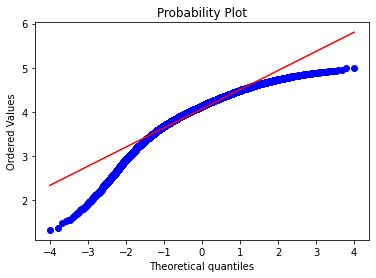

In [19]:
from scipy import stats 
fig = plt.figure() 
prob = stats.probplot(df['score'], plot=plt)

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


- Total number of ratings: 21987
- Mean of distribution of rating : 4.0676891002683195
- Standard deviation: 0.4488755964730774


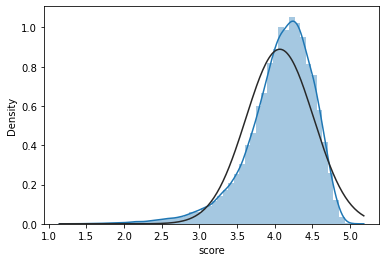

In [20]:
sns.distplot(df['score'],fit=stats.norm)
print('- Total number of ratings:', len(df['score']))
print('- Mean of distribution of rating :', np.mean(df['score']))
print('- Standard deviation:', np.std(df['score']))

<ipython-input-21-0acddf910d3f>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  pd.plotting.scatter_matrix(df[['ratings','installs_day','updated_days','compound','score']], ax=ax);


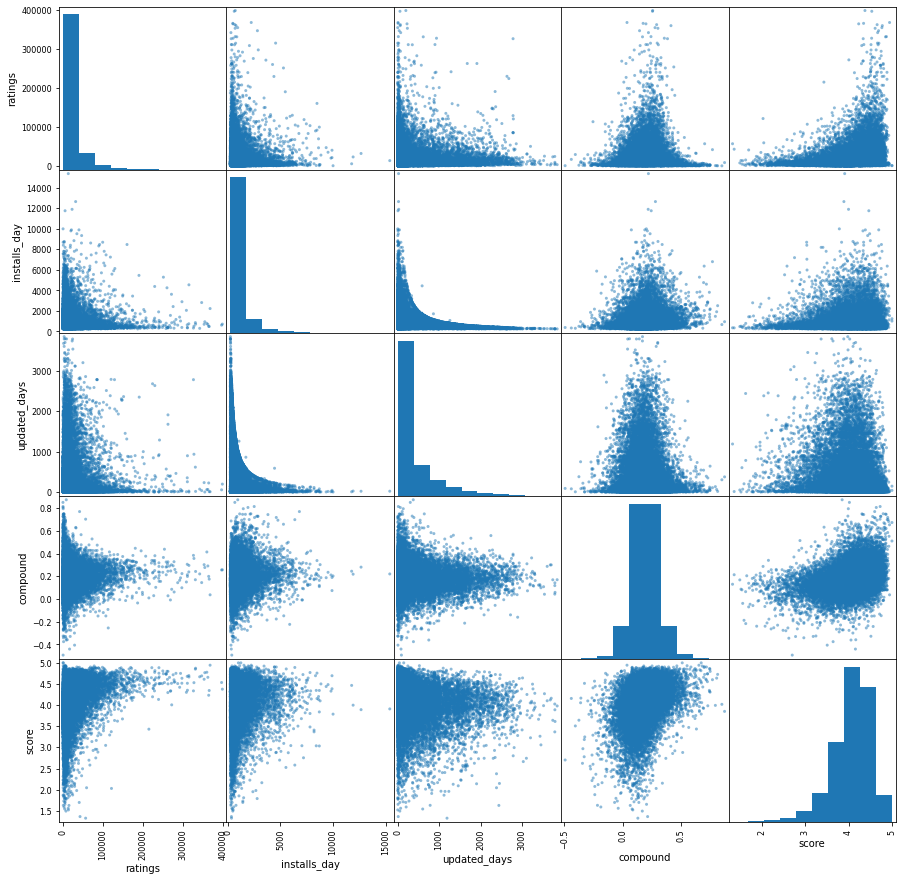

In [21]:
fig, ax = plt.subplots(figsize=(15, 15))
pd.plotting.scatter_matrix(df[['ratings','installs_day','updated_days','compound','score']], ax=ax);

In [22]:
X_train.columns

Index(['ratings', 'free', 'containsAds', 'editorsChoice', 'top_developer',
       'installs_day', 'updated_days', 'has_video', 'compound', 'year',
       'genre_Adventure', 'genre_Arcade', 'genre_Art & Design',
       'genre_Auto & Vehicles', 'genre_Beauty', 'genre_Board',
       'genre_Books & Reference', 'genre_Business', 'genre_Card',
       'genre_Casino', 'genre_Casual', 'genre_Comics', 'genre_Communication',
       'genre_Dating', 'genre_Education', 'genre_Entertainment',
       'genre_Finance', 'genre_Food & Drink', 'genre_Health & Fitness',
       'genre_House & Home', 'genre_Libraries & Demo', 'genre_Lifestyle',
       'genre_Maps & Navigation', 'genre_Medical', 'genre_Music & Audio',
       'genre_News & Magazines', 'genre_Parenting', 'genre_Personalization',
       'genre_Photography', 'genre_Productivity', 'genre_Puzzle',
       'genre_Racing', 'genre_Role Playing', 'genre_Shopping',
       'genre_Simulation', 'genre_Social', 'genre_Sports', 'genre_Strategy',
       'genre_

## No pipeline

In [23]:
features = ['ratings_cubed']

In [24]:
lr = LinearRegression()

lr.fit(X_train[features], y_train)

y_pred = lr.predict(X_train[features])
print('R^2 of linear regression on train set: {:.2f}'.format(lr.score(X_train[features], y_train)))
print('MSE of linear regression on train set: {:.2f}'.format((mean_squared_error(y_train, y_pred))))
print('MAE of linear regression on train set: {:.2f}'.format((mean_absolute_error(y_train, y_pred))))

R^2 of linear regression on train set: 0.12
MSE of linear regression on train set: 0.18
MAE of linear regression on train set: 0.31


In [25]:
y_predv = lr.predict(X_val[features])
print('R^2 of linear regression on val set: {:.2f}'.format(lr.score(X_val[features], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_predv))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_predv))))

R^2 of linear regression on val set: 0.11
MSE of linear regression on val set: 0.17
MAE of linear regression on val set: 0.30


In [26]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features].columns, lr.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings_cubed : 0.02


In [27]:
check = X_val.copy()
check['score'] = y_val
check['pred'] = lr.predict(X_val[features])
check['resid'] = check['pred'] - check['score']

In [28]:
high_resid = check.sort_values('resid',ascending =False).head(600)

In [29]:
check.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,compound,year,...,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,ratings_cubed,score,pred,resid
7390,57642.0,1,0,0,0,357.781753,1190,1,0.130537,2013,...,0.0,0.0,0.0,0.0,0.0,0.0,38.628960,1.324779,4.313323,2.988544
3260,6117.0,1,1,0,0,1430.615165,194,0,-0.069253,2019,...,0.0,0.0,0.0,0.0,0.0,0.0,18.288559,1.696825,3.958509,2.261684
8013,17878.0,1,1,0,0,259.538022,21,0,-0.012823,2010,...,0.0,0.0,0.0,0.0,0.0,1.0,26.148070,1.929050,4.095609,2.166559
17098,3380.0,1,1,0,0,717.360115,1234,0,0.173240,2017,...,0.0,0.0,0.0,0.0,0.0,1.0,15.007404,1.958580,3.901274,1.942694
1538,9227.0,1,1,0,0,416.840350,772,0,0.004940,2014,...,0.0,0.0,0.0,0.0,0.0,1.0,20.974269,2.075757,4.005358,1.929601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6965,8987.0,1,1,0,1,4444.444444,70,0,0.359574,2020,...,0.0,0.0,0.0,0.0,0.0,0.0,20.790818,4.901379,4.002158,-0.899220
6651,1205.0,1,1,0,0,2512.562814,15,0,0.815532,2020,...,0.0,1.0,0.0,0.0,0.0,0.0,10.641324,4.727272,3.825113,-0.902160
8064,4457.0,1,1,0,1,2816.901408,145,1,0.621763,2020,...,0.0,0.0,0.0,0.0,0.0,1.0,16.456882,4.864333,3.926558,-0.937775
4354,3684.0,1,1,0,1,2123.142251,82,1,0.748811,2019,...,0.0,0.0,0.0,1.0,0.0,0.0,15.444477,4.850948,3.908898,-0.942050


In [30]:
low_resid = check[(check['resid'] >= -0.1) & (check['resid'] <= 0.1)]

In [31]:
high_resid.describe()

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,compound,year,...,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,ratings_cubed,score,pred,resid
count,600.000000,600.000000,600.000000,600.000000,600.0,600.000000,600.000000,600.000000,600.000000,600.000000,...,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,20240.275000,0.998333,0.736667,0.005000,0.0,760.662604,531.055000,0.268333,0.119536,2015.446667,...,0.025000,0.006667,0.006667,0.043333,0.056667,0.180000,23.918810,3.396306,4.056722,0.660416
std,29289.791104,0.040825,0.440809,0.070593,0.0,796.405687,670.616992,0.443462,0.104495,2.498846,...,0.156255,0.081445,0.081445,0.203776,0.231397,0.384508,8.892365,0.402019,0.155116,0.364642
min,1112.000000,0.000000,0.000000,0.000000,0.0,248.138958,0.000000,0.000000,-0.341476,2010.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.360203,1.324779,3.820209,0.292405
25%,5475.000000,1.000000,0.000000,0.000000,0.0,391.313259,57.000000,0.000000,0.059261,2014.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.624936,3.231800,3.946933,0.403704
50%,10828.000000,1.000000,1.000000,0.000000,0.0,555.865056,245.500000,0.000000,0.120166,2016.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.123271,3.487443,4.025401,0.541565
75%,22207.750000,1.000000,1.000000,0.000000,0.0,798.403576,782.000000,1.000000,0.184350,2017.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,28.108313,3.647944,4.129803,0.782505
max,272439.000000,1.000000,1.000000,1.000000,0.0,12658.227848,3799.000000,1.000000,0.633394,2020.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,64.827075,4.331535,4.770317,2.988544


In [32]:
low_resid.describe()

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,compound,year,...,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,ratings_cubed,score,pred,resid
count,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,...,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000
mean,23295.211321,0.994969,0.835220,0.005031,0.005031,974.105616,385.254088,0.376101,0.188314,2016.188679,...,0.015094,0.006289,0.005031,0.049057,0.046541,0.179874,24.903120,4.079189,4.073892,-0.005297
std,29315.568481,0.070799,0.371215,0.070799,0.070799,963.738647,527.872538,0.484711,0.105944,2.496773,...,0.122005,0.079105,0.070799,0.216122,0.210786,0.384324,9.733259,0.176293,0.169785,0.057054
min,1008.000000,0.000000,0.000000,0.000000,0.000000,248.694355,0.000000,0.000000,-0.207279,2010.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.026596,3.732143,3.814389,-0.099887
25%,5479.000000,1.000000,1.000000,0.000000,0.000000,444.645228,37.000000,0.000000,0.124254,2014.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.629246,3.948133,3.947008,-0.054307
50%,11513.000000,1.000000,1.000000,0.000000,0.000000,676.589986,175.000000,0.000000,0.189658,2017.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.580289,4.051696,4.033373,-0.004251
75%,28746.500000,1.000000,1.000000,0.000000,0.000000,1051.543314,487.000000,1.000000,0.252316,2018.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.633381,4.186324,4.173850,0.043180
max,232572.000000,1.000000,1.000000,1.000000,1.000000,8695.652174,3319.000000,1.000000,0.731161,2020.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,61.496794,4.647038,4.712224,0.099208


/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


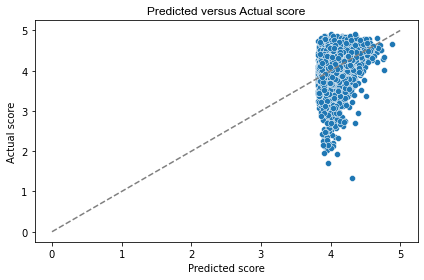

In [33]:
fig, ax = plt.subplots()
sns.scatterplot(y_predv, y_val)
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
ax.plot(np.linspace(0,5,5), np.linspace(0,5,5), ls="--", c="0.5")
plt.tight_layout()
plt.title('Predicted versus Actual score',family='arial',fontsize=12);
#plt.yticks(np.linspace(0,5,11), ['0','0.5','1.0','1.5','2.0','2.5','3.0','3.5','4.0','4.5','5.0'])
#plt.xticks(np.linspace(0,6,13), ['0','0.5','1.0','1.5','2.0','2.5','3.0','3.5','4.0','4.5','5.0','5.5','6.0'])
plt.tight_layout()
#plt.savefig('predictedactual_apps.svg');
plt.show;

This model is overpredicting values

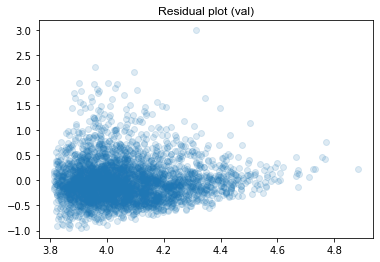

In [34]:
plt.scatter(check['pred'],check['resid'],alpha = 0.15)
plt.title('Residual plot (val)',family='arial',fontsize=12);

## Add compound

In [35]:
features2 = ['ratings_cubed','compound']

In [36]:
lr2 = LinearRegression()

lr2.fit(X_train[features2], y_train)

y_pred2 = lr2.predict(X_train[features2])
print('R^2 of linear regression on train set: {:.2f}'.format(lr2.score(X_train[features2], y_train)))
print('MSE of linear regression on train set: {:.2f}'.format((mean_squared_error(y_train, y_pred))))
print('MAE of linear regression on train set: {:.2f}'.format((mean_absolute_error(y_train, y_pred))))

R^2 of linear regression on train set: 0.25
MSE of linear regression on train set: 0.18
MAE of linear regression on train set: 0.31


In [37]:
y_predv2 = lr2.predict(X_val[features2])
print('R^2 of linear regression on val set: {:.2f}'.format(lr2.score(X_val[features2], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_predv))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_predv))))

R^2 of linear regression on val set: 0.24
MSE of linear regression on val set: 0.17
MAE of linear regression on val set: 0.30


In [38]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features2].columns, lr2.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings_cubed : 0.02
compound : 1.43


In [39]:
check2 = X_val.copy()
check2['score'] = y_val
check2['pred'] = lr2.predict(X_val[features2])
check2['resid'] = check2['pred'] - check2['score']

In [40]:
check2.sort_values('resid',ascending = False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,compound,year,...,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,ratings_cubed,score,pred,resid
7390,57642.0,1,0,0,0,357.781753,1190,1,0.130537,2013,...,0.0,0.0,0.0,0.0,0.0,0.0,38.628960,1.324779,4.214526,2.889747
17098,3380.0,1,1,0,0,717.360115,1234,0,0.173240,2017,...,0.0,0.0,0.0,0.0,0.0,1.0,15.007404,1.958580,3.878505,1.919926
3260,6117.0,1,1,0,0,1430.615165,194,0,-0.069253,2019,...,0.0,0.0,0.0,0.0,0.0,0.0,18.288559,1.696825,3.586771,1.889946
8013,17878.0,1,1,0,0,259.538022,21,0,-0.012823,2010,...,0.0,0.0,0.0,0.0,0.0,1.0,26.148070,1.929050,3.799625,1.870574
3309,5985.0,1,0,0,0,308.832613,350,0,0.145100,2012,...,0.0,0.0,0.0,0.0,0.0,0.0,18.156051,2.030100,3.891183,1.861083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15433,18778.0,1,1,0,1,301.659125,72,0,0.022644,2012,...,0.0,0.0,0.0,0.0,0.0,0.0,26.579682,4.758382,3.857618,-0.900765
10764,54103.0,1,0,0,1,1721.170396,5,0,-0.146588,2019,...,0.0,0.0,0.0,0.0,0.0,0.0,37.821648,4.751856,3.804516,-0.947340
8091,10811.0,1,1,0,1,2941.176471,20,1,-0.021467,2020,...,0.0,0.0,0.0,0.0,0.0,0.0,22.111691,4.684882,3.719402,-0.965479
10703,28044.0,1,0,0,0,1270.648030,0,0,-0.241804,2019,...,0.0,0.0,0.0,0.0,1.0,0.0,30.381787,4.566454,3.543233,-1.023221


/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


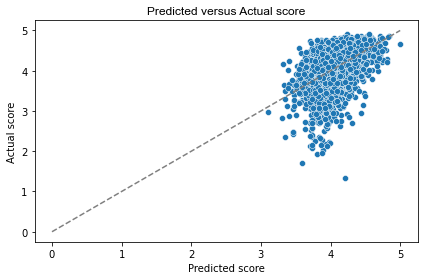

In [41]:
fig, ax = plt.subplots()
sns.scatterplot(y_predv2, y_val)
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
ax.plot(np.linspace(0,5,5), np.linspace(0,5,5), ls="--", c="0.5")
plt.tight_layout()
plt.title('Predicted versus Actual score',family='arial',fontsize=12);
#plt.yticks(np.linspace(0,5,11), ['0','0.5','1.0','1.5','2.0','2.5','3.0','3.5','4.0','4.5','5.0'])
#plt.xticks(np.linspace(0,6,13), ['0','0.5','1.0','1.5','2.0','2.5','3.0','3.5','4.0','4.5','5.0','5.5','6.0'])
plt.tight_layout()
#plt.savefig('predictedactual_apps.svg');
plt.show;

## Add updated_days

In [42]:
X_train['updated_sqrt'] = X_train['updated_days'] ** 0.25
X_val['updated_sqrt'] = X_val['updated_days'] ** 0.25

<ipython-input-42-ba05ac944f75>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['updated_sqrt'] = X_train['updated_days'] ** 0.25
<ipython-input-42-ba05ac944f75>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['updated_sqrt'] = X_val['updated_days'] ** 0.25


In [43]:
features3 = ['ratings_cubed','compound','updated_sqrt']

In [44]:
lr3 = LinearRegression()

lr3.fit(X_train[features3], y_train)

y_pred3 = lr3.predict(X_train[features3])
print('R^2 of linear regression on train set: {:.2f}'.format(lr3.score(X_train[features3], y_train)))
print('MSE of linear regression on train set: {:.2f}'.format((mean_squared_error(y_train, y_pred))))
print('MAE of linear regression on train set: {:.2f}'.format((mean_absolute_error(y_train, y_pred))))

R^2 of linear regression on train set: 0.26
MSE of linear regression on train set: 0.18
MAE of linear regression on train set: 0.31


In [45]:
y_predv3 = lr3.predict(X_val[features3])
print('R^2 of linear regression on val set: {:.2f}'.format(lr3.score(X_val[features3], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_predv))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_predv))))

R^2 of linear regression on val set: 0.26
MSE of linear regression on val set: 0.17
MAE of linear regression on val set: 0.30


In [46]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features3].columns, lr3.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings_cubed : 0.02
compound : 1.41
updated_sqrt : -0.03


In [47]:
check3 = X_val.copy()
check3['score'] = y_val
check3['pred'] = lr3.predict(X_val[features3])
check3['resid'] = check3['pred'] - check3['score']

In [48]:
check3.sort_values('resid',ascending = False).head(60)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,compound,year,...,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,ratings_cubed,updated_sqrt,score,pred,resid
7390,57642.0,1,0,0,0,357.781753,1190,1,0.130537,2013,...,0.0,0.0,0.0,0.0,0.0,38.628960,5.873362,1.324779,4.135948,2.811169
8013,17878.0,1,1,0,0,259.538022,21,0,-0.012823,2010,...,0.0,0.0,0.0,0.0,1.0,26.148070,2.140695,1.929050,3.850830,1.921780
3260,6117.0,1,1,0,0,1430.615165,194,0,-0.069253,2019,...,0.0,0.0,0.0,0.0,0.0,18.288559,3.732076,1.696825,3.593323,1.896498
16220,11227.0,1,0,0,0,332.889481,6,0,0.165533,2012,...,0.0,0.0,0.0,0.0,0.0,22.391743,1.565085,2.199340,4.059008,1.859668
16337,11749.0,1,0,0,0,411.353353,64,0,0.135694,2014,...,0.0,0.0,0.0,0.0,0.0,22.733535,2.828427,2.123090,3.982360,1.859270
17098,3380.0,1,1,0,0,717.360115,1234,0,0.173240,2017,...,0.0,0.0,0.0,0.0,1.0,15.007404,5.926916,1.958580,3.811148,1.852568
3309,5985.0,1,0,0,0,308.832613,350,0,0.145100,2012,...,0.0,0.0,0.0,0.0,0.0,18.156051,4.325308,2.030100,3.873664,1.843564
14205,7044.0,1,1,0,0,430.292599,41,0,0.150945,2014,...,0.0,0.0,0.0,0.0,0.0,19.169309,2.530440,2.187500,3.955483,1.767983
10601,6694.0,1,0,0,0,331.785003,507,0,0.196174,2012,...,0.0,0.0,0.0,0.0,0.0,18.846407,4.745172,2.231689,3.943301,1.711612
19769,6510.0,1,0,0,0,307.314075,364,0,0.116068,2012,...,0.0,0.0,0.0,0.0,0.0,18.672121,4.367927,2.153374,3.839858,1.686484


/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


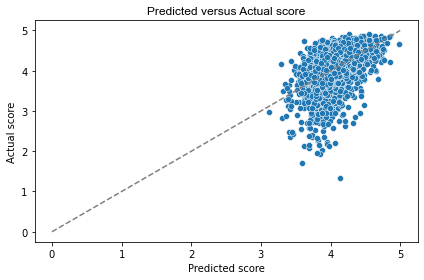

In [49]:
fig, ax = plt.subplots()
sns.scatterplot(y_predv3, y_val)
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
ax.plot(np.linspace(0,5,5), np.linspace(0,5,5), ls="--", c="0.5")
plt.tight_layout()
plt.title('Predicted versus Actual score',family='arial',fontsize=12);
#plt.yticks(np.linspace(0,5,11), ['0','0.5','1.0','1.5','2.0','2.5','3.0','3.5','4.0','4.5','5.0'])
#plt.xticks(np.linspace(0,6,13), ['0','0.5','1.0','1.5','2.0','2.5','3.0','3.5','4.0','4.5','5.0','5.5','6.0'])
plt.tight_layout()
#plt.savefig('predictedactual_apps.svg');
plt.show;

## Top developer

In [50]:
features3 = ['ratings_cubed','compound','updated_sqrt','top_developer']

In [51]:
lr3 = LinearRegression()

lr3.fit(X_train[features3], y_train)

y_pred3 = lr3.predict(X_train[features3])
print('R^2 of linear regression on train set: {:.2f}'.format(lr3.score(X_train[features3], y_train)))
print('MSE of linear regression on train set: {:.2f}'.format((mean_squared_error(y_train, y_pred))))
print('MAE of linear regression on train set: {:.2f}'.format((mean_absolute_error(y_train, y_pred))))

R^2 of linear regression on train set: 0.31
MSE of linear regression on train set: 0.18
MAE of linear regression on train set: 0.31


In [52]:
y_predv3 = lr3.predict(X_val[features3])
print('R^2 of linear regression on val set: {:.2f}'.format(lr3.score(X_val[features3], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_predv))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_predv))))

R^2 of linear regression on val set: 0.31
MSE of linear regression on val set: 0.17
MAE of linear regression on val set: 0.30


In [53]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features3].columns, lr3.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings_cubed : 0.01
compound : 1.30
updated_sqrt : -0.03
top_developer : 0.46


In [54]:
check3 = X_val.copy()
check3['score'] = y_val
check3['pred'] = lr3.predict(X_val[features3])
check3['resid'] = check3['pred'] - check3['score']

In [55]:
check3.sort_values('resid',ascending = False).head(60)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,compound,year,...,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,ratings_cubed,updated_sqrt,score,pred,resid
7390,57642.0,1,0,0,0,357.781753,1190,1,0.130537,2013,...,0.0,0.0,0.0,0.0,0.0,38.628960,5.873362,1.324779,4.091972,2.767193
3260,6117.0,1,1,0,0,1430.615165,194,0,-0.069253,2019,...,0.0,0.0,0.0,0.0,0.0,18.288559,3.732076,1.696825,3.610011,1.913185
8013,17878.0,1,1,0,0,259.538022,21,0,-0.012823,2010,...,0.0,0.0,0.0,0.0,1.0,26.148070,2.140695,1.929050,3.832581,1.903530
17098,3380.0,1,1,0,0,717.360115,1234,0,0.173240,2017,...,0.0,0.0,0.0,0.0,1.0,15.007404,5.926916,1.958580,3.823262,1.864682
3309,5985.0,1,0,0,0,308.832613,350,0,0.145100,2012,...,0.0,0.0,0.0,0.0,0.0,18.156051,4.325308,2.030100,3.871638,1.841538
16337,11749.0,1,0,0,0,411.353353,64,0,0.135694,2014,...,0.0,0.0,0.0,0.0,0.0,22.733535,2.828427,2.123090,3.961184,1.838094
16220,11227.0,1,0,0,0,332.889481,6,0,0.165533,2012,...,0.0,0.0,0.0,0.0,0.0,22.391743,1.565085,2.199340,4.028447,1.829107
14205,7044.0,1,1,0,0,430.292599,41,0,0.150945,2014,...,0.0,0.0,0.0,0.0,0.0,19.169309,2.530440,2.187500,3.940120,1.752620
10601,6694.0,1,0,0,0,331.785003,507,0,0.196174,2012,...,0.0,0.0,0.0,0.0,0.0,18.846407,4.745172,2.231689,3.936548,1.704859
19769,6510.0,1,0,0,0,307.314075,364,0,0.116068,2012,...,0.0,0.0,0.0,0.0,0.0,18.672121,4.367927,2.153374,3.839791,1.686417


/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


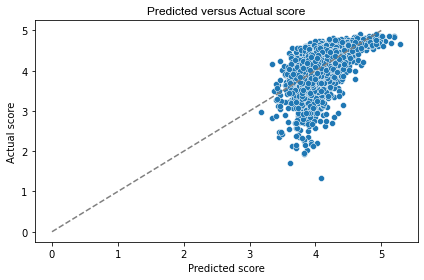

In [56]:
fig, ax = plt.subplots()
sns.scatterplot(y_predv3, y_val)
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
ax.plot(np.linspace(0,5,5), np.linspace(0,5,5), ls="--", c="0.5")
plt.tight_layout()
plt.title('Predicted versus Actual score',family='arial',fontsize=12);
#plt.yticks(np.linspace(0,5,11), ['0','0.5','1.0','1.5','2.0','2.5','3.0','3.5','4.0','4.5','5.0'])
#plt.xticks(np.linspace(0,6,13), ['0','0.5','1.0','1.5','2.0','2.5','3.0','3.5','4.0','4.5','5.0','5.5','6.0'])
plt.tight_layout()
#plt.savefig('predictedactual_apps.svg');
plt.show;

## Compound transform

In [57]:
# X_train['comp_transform'] = 0
# X_val['comp_transform'] = 0

# X_train.loc[X_train['compound'] <= 0.05, 'comp_transform'] = -2
# #X_train.loc[(X_train['compound'] > 0.05) & (X_train['compound']<=0.1), 'comp_transform'] == 0
# X_train.loc[X_train['compound'] > 0.1, 'comp_transform'] = 1
            
# X_val.loc[X_val['compound'] <= 0.05, 'comp_transform'] = -2
# #X_val.loc[(X_val['compound'] > 0.05) & (X_val['compound'] <=0.1), 'comp_transform'] == 0
# X_val.loc[X_val['compound'] > 0.1, 'comp_transform'] = 1

In [58]:
features4 = ['ratings_cubed','compound','updated_sqrt','top_developer']

In [59]:
lr4 = LinearRegression()

lr4.fit(X_train[features4], y_train)

y_pred4 = lr4.predict(X_train[features4])
print('R^2 of linear regression on train set: {:.2f}'.format(lr4.score(X_train[features4], y_train)))
print('MSE of linear regression on train set: {:.2f}'.format((mean_squared_error(y_train, y_pred))))
print('MAE of linear regression on train set: {:.2f}'.format((mean_absolute_error(y_train, y_pred))))

R^2 of linear regression on train set: 0.31
MSE of linear regression on train set: 0.18
MAE of linear regression on train set: 0.31


In [60]:
y_predv4 = lr4.predict(X_val[features4])
print('R^2 of linear regression on val set: {:.2f}'.format(lr4.score(X_val[features4], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_predv))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_predv))))

R^2 of linear regression on val set: 0.31
MSE of linear regression on val set: 0.17
MAE of linear regression on val set: 0.30


In [61]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features4].columns, lr4.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings_cubed : 0.01
compound : 1.30
updated_sqrt : -0.03
top_developer : 0.46


In [62]:
check4 = X_val.copy()
check4['score'] = y_val
check4['pred'] = lr4.predict(X_val[features4])
check4['resid'] = check4['pred'] - check4['score']

In [63]:
check4.sort_values('resid',ascending = False).head(60)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,compound,year,...,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,ratings_cubed,updated_sqrt,score,pred,resid
7390,57642.0,1,0,0,0,357.781753,1190,1,0.130537,2013,...,0.0,0.0,0.0,0.0,0.0,38.628960,5.873362,1.324779,4.091972,2.767193
3260,6117.0,1,1,0,0,1430.615165,194,0,-0.069253,2019,...,0.0,0.0,0.0,0.0,0.0,18.288559,3.732076,1.696825,3.610011,1.913185
8013,17878.0,1,1,0,0,259.538022,21,0,-0.012823,2010,...,0.0,0.0,0.0,0.0,1.0,26.148070,2.140695,1.929050,3.832581,1.903530
17098,3380.0,1,1,0,0,717.360115,1234,0,0.173240,2017,...,0.0,0.0,0.0,0.0,1.0,15.007404,5.926916,1.958580,3.823262,1.864682
3309,5985.0,1,0,0,0,308.832613,350,0,0.145100,2012,...,0.0,0.0,0.0,0.0,0.0,18.156051,4.325308,2.030100,3.871638,1.841538
16337,11749.0,1,0,0,0,411.353353,64,0,0.135694,2014,...,0.0,0.0,0.0,0.0,0.0,22.733535,2.828427,2.123090,3.961184,1.838094
16220,11227.0,1,0,0,0,332.889481,6,0,0.165533,2012,...,0.0,0.0,0.0,0.0,0.0,22.391743,1.565085,2.199340,4.028447,1.829107
14205,7044.0,1,1,0,0,430.292599,41,0,0.150945,2014,...,0.0,0.0,0.0,0.0,0.0,19.169309,2.530440,2.187500,3.940120,1.752620
10601,6694.0,1,0,0,0,331.785003,507,0,0.196174,2012,...,0.0,0.0,0.0,0.0,0.0,18.846407,4.745172,2.231689,3.936548,1.704859
19769,6510.0,1,0,0,0,307.314075,364,0,0.116068,2012,...,0.0,0.0,0.0,0.0,0.0,18.672121,4.367927,2.153374,3.839791,1.686417


/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


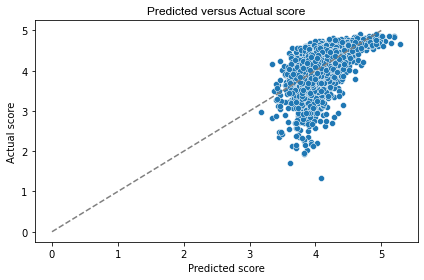

In [64]:
fig, ax = plt.subplots()
sns.scatterplot(y_predv4, y_val)
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
ax.plot(np.linspace(0,5,5), np.linspace(0,5,5), ls="--", c="0.5")
plt.tight_layout()
plt.title('Predicted versus Actual score',family='arial',fontsize=12);
#plt.yticks(np.linspace(0,5,11), ['0','0.5','1.0','1.5','2.0','2.5','3.0','3.5','4.0','4.5','5.0'])
#plt.xticks(np.linspace(0,6,13), ['0','0.5','1.0','1.5','2.0','2.5','3.0','3.5','4.0','4.5','5.0','5.5','6.0'])
plt.tight_layout()
#plt.savefig('predictedactual_apps.svg');
plt.show;

## Free

In [65]:
features5 = ['ratings_cubed','compound','updated_sqrt','top_developer','free']

In [66]:
lr5 = LinearRegression()

lr5.fit(X_train[features5], y_train)

y_pred5 = lr5.predict(X_train[features5])
print('R^2 of linear regression on train set: {:.2f}'.format(lr5.score(X_train[features5], y_train)))
print('MSE of linear regression on train set: {:.2f}'.format((mean_squared_error(y_train, y_pred))))
print('MAE of linear regression on train set: {:.2f}'.format((mean_absolute_error(y_train, y_pred))))

R^2 of linear regression on train set: 0.32
MSE of linear regression on train set: 0.18
MAE of linear regression on train set: 0.31


In [67]:
y_predv5 = lr5.predict(X_val[features5])
print('R^2 of linear regression on val set: {:.2f}'.format(lr5.score(X_val[features5], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_predv))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_predv))))

R^2 of linear regression on val set: 0.31
MSE of linear regression on val set: 0.17
MAE of linear regression on val set: 0.30


In [68]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features5].columns, lr5.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings_cubed : 0.01
compound : 1.30
updated_sqrt : -0.03
top_developer : 0.46
free : 0.10


In [69]:
check5 = X_val.copy()
check5['score'] = y_val
check5['pred'] = lr5.predict(X_val[features5])
check5['resid'] = check5['pred'] - check5['score']

In [70]:
check5.sort_values('resid',ascending = False).head(60)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,compound,year,...,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,ratings_cubed,updated_sqrt,score,pred,resid
7390,57642.0,1,0,0,0,357.781753,1190,1,0.130537,2013,...,0.0,0.0,0.0,0.0,0.0,38.628960,5.873362,1.324779,4.093451,2.768673
3260,6117.0,1,1,0,0,1430.615165,194,0,-0.069253,2019,...,0.0,0.0,0.0,0.0,0.0,18.288559,3.732076,1.696825,3.609886,1.913061
8013,17878.0,1,1,0,0,259.538022,21,0,-0.012823,2010,...,0.0,0.0,0.0,0.0,1.0,26.148070,2.140695,1.929050,3.832944,1.903894
17098,3380.0,1,1,0,0,717.360115,1234,0,0.173240,2017,...,0.0,0.0,0.0,0.0,1.0,15.007404,5.926916,1.958580,3.823087,1.864507
3309,5985.0,1,0,0,0,308.832613,350,0,0.145100,2012,...,0.0,0.0,0.0,0.0,0.0,18.156051,4.325308,2.030100,3.871595,1.841495
16337,11749.0,1,0,0,0,411.353353,64,0,0.135694,2014,...,0.0,0.0,0.0,0.0,0.0,22.733535,2.828427,2.123090,3.961384,1.838294
16220,11227.0,1,0,0,0,332.889481,6,0,0.165533,2012,...,0.0,0.0,0.0,0.0,0.0,22.391743,1.565085,2.199340,4.028565,1.829225
14205,7044.0,1,1,0,0,430.292599,41,0,0.150945,2014,...,0.0,0.0,0.0,0.0,0.0,19.169309,2.530440,2.187500,3.940057,1.752557
10601,6694.0,1,0,0,0,331.785003,507,0,0.196174,2012,...,0.0,0.0,0.0,0.0,0.0,18.846407,4.745172,2.231689,3.936590,1.704901
19769,6510.0,1,0,0,0,307.314075,364,0,0.116068,2012,...,0.0,0.0,0.0,0.0,0.0,18.672121,4.367927,2.153374,3.839778,1.686404


/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


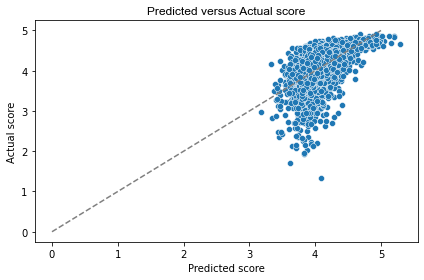

In [71]:
fig, ax = plt.subplots()
sns.scatterplot(y_predv5, y_val)
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
ax.plot(np.linspace(0,5,5), np.linspace(0,5,5), ls="--", c="0.5")
plt.tight_layout()
plt.title('Predicted versus Actual score',family='arial',fontsize=12);
#plt.yticks(np.linspace(0,5,11), ['0','0.5','1.0','1.5','2.0','2.5','3.0','3.5','4.0','4.5','5.0'])
#plt.xticks(np.linspace(0,6,13), ['0','0.5','1.0','1.5','2.0','2.5','3.0','3.5','4.0','4.5','5.0','5.5','6.0'])
plt.tight_layout()
#plt.savefig('predictedactual_apps.svg');
plt.show;

## Year

In [72]:
features6 = ['ratings_cubed','compound','updated_sqrt','top_developer','free','genre_Adventure',
       'genre_Auto & Vehicles', 'genre_Beauty', 'genre_Board',
       'genre_Books & Reference', 'genre_Business', 'genre_Card',
       'genre_Casino', 'genre_Casual', 'genre_Communication',
       'genre_Dating', 'genre_Education', 'genre_Entertainment',
       'genre_Finance', 'genre_Food & Drink', 'genre_Health & Fitness',
       'genre_House & Home', 'genre_Libraries & Demo', 'genre_Lifestyle',
       'genre_Maps & Navigation', 'genre_Medical', 'genre_Music & Audio',
       'genre_News & Magazines', 'genre_Parenting', 'genre_Personalization',
       'genre_Photography', 'genre_Productivity', 'genre_Puzzle',
       'genre_Racing', 'genre_Role Playing', 
       'genre_Simulation', 'genre_Social', 'genre_Sports', 'genre_Strategy',
       'genre_Tools', 'genre_Travel & Local',
       'genre_Video Players & Editors', 'genre_Weather']

In [73]:
lr6 = LinearRegression()

lr6.fit(X_train[features6], y_train)

y_pred6 = lr6.predict(X_train[features6])
print('R^2 of linear regression on train set: {:.2f}'.format(lr6.score(X_train[features6], y_train)))
print('MSE of linear regression on train set: {:.2f}'.format((mean_squared_error(y_train, y_pred))))
print('MAE of linear regression on train set: {:.2f}'.format((mean_absolute_error(y_train, y_pred))))

R^2 of linear regression on train set: 0.34
MSE of linear regression on train set: 0.18
MAE of linear regression on train set: 0.31


In [74]:
y_predv6 = lr6.predict(X_val[features6])
print('R^2 of linear regression on val set: {:.2f}'.format(lr6.score(X_val[features6], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_predv))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_predv))))

R^2 of linear regression on val set: 0.33
MSE of linear regression on val set: 0.17
MAE of linear regression on val set: 0.30


In [75]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features6].columns, lr6.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings_cubed : 0.01
compound : 1.27
updated_sqrt : -0.02
top_developer : 0.43
free : 0.08
genre_Adventure : -0.09
genre_Auto & Vehicles : 0.10
genre_Beauty : -0.16
genre_Board : 0.05
genre_Books & Reference : 0.12
genre_Business : 0.07
genre_Card : 0.06
genre_Casino : 0.08
genre_Casual : -0.04
genre_Communication : -0.02
genre_Dating : -0.17
genre_Education : 0.04
genre_Entertainment : -0.07
genre_Finance : -0.04
genre_Food & Drink : 0.02
genre_Health & Fitness : 0.03
genre_House & Home : -0.07
genre_Libraries & Demo : -0.03
genre_Lifestyle : -0.03
genre_Maps & Navigation : 0.07
genre_Medical : 0.05
genre_Music & Audio : 0.03
genre_News & Magazines : -0.03
genre_Parenting : 0.05
genre_Personalization : 0.11
genre_Photography : -0.04
genre_Productivity : 0.03
genre_Puzzle : 0.08
genre_Racing : 0.00
genre_Role Playing : -0.12
genre_Simulation : -0.12
genre_Social : -0.04
genre_Sports : -0.03
genre_Strategy : -0.06
genre_Tools : 0.05
genre_Travel & Local : 

In [76]:
check6 = X_val.copy()
check6['score'] = y_val
check6['pred'] = lr6.predict(X_val[features6])
check6['resid'] = check6['pred'] - check6['score']

In [77]:
check6.sort_values('resid',ascending = False).head(60)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,compound,year,...,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,ratings_cubed,updated_sqrt,score,pred,resid
7390,57642.0,1,0,0,0,357.781753,1190,1,0.130537,2013,...,0.0,0.0,0.0,0.0,0.0,38.628960,5.873362,1.324779,4.109097,2.784318
3260,6117.0,1,1,0,0,1430.615165,194,0,-0.069253,2019,...,0.0,0.0,0.0,0.0,0.0,18.288559,3.732076,1.696825,3.598303,1.901478
3309,5985.0,1,0,0,0,308.832613,350,0,0.145100,2012,...,0.0,0.0,0.0,0.0,0.0,18.156051,4.325308,2.030100,3.924544,1.894444
16337,11749.0,1,0,0,0,411.353353,64,0,0.135694,2014,...,0.0,0.0,0.0,0.0,0.0,22.733535,2.828427,2.123090,4.014096,1.891006
8013,17878.0,1,1,0,0,259.538022,21,0,-0.012823,2010,...,0.0,0.0,0.0,0.0,1.0,26.148070,2.140695,1.929050,3.813310,1.884259
17098,3380.0,1,1,0,0,717.360115,1234,0,0.173240,2017,...,0.0,0.0,0.0,0.0,1.0,15.007404,5.926916,1.958580,3.759106,1.800526
16220,11227.0,1,0,0,0,332.889481,6,0,0.165533,2012,...,0.0,0.0,0.0,0.0,0.0,22.391743,1.565085,2.199340,3.988320,1.788980
19769,6510.0,1,0,0,0,307.314075,364,0,0.116068,2012,...,0.0,0.0,0.0,0.0,0.0,18.672121,4.367927,2.153374,3.914267,1.760893
10601,6694.0,1,0,0,0,331.785003,507,0,0.196174,2012,...,0.0,0.0,0.0,0.0,0.0,18.846407,4.745172,2.231689,3.988564,1.756875
1538,9227.0,1,1,0,0,416.840350,772,0,0.004940,2014,...,0.0,0.0,0.0,0.0,1.0,20.974269,5.271137,2.075757,3.762888,1.687130


In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(y_predv3, y_val)
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
ax.plot(np.linspace(0,5,5), np.linspace(0,5,5), ls="--", c="0.6")
plt.tight_layout()
plt.title('Predicted versus Actual score',family='arial',fontsize=12);
plt.tight_layout()
plt.show;

### Test

In [79]:
X_test_cont = X_test[['ratings','free','containsAds','editorsChoice','top_developer',
        'installs_day','updated_days','has_video','compound','year']]

In [80]:
X_test_cont['ratings_cubed'] = np.cbrt(X_test_cont['ratings'])
X_test_cont['updated_sqrt'] = X_test_cont['updated_days'] ** 0.25

<ipython-input-80-63be0df4c568>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_cont['ratings_cubed'] = np.cbrt(X_test_cont['ratings'])


In [81]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(X_test[['genre','contentRating']])

ohe_x_test = ohe.transform(X_test[['genre','contentRating']])

columns = ohe.get_feature_names(['genre','contentRating'])

ohe_x_test_df = pd.DataFrame(ohe_x_test, columns=columns, index=X_test.index)

In [82]:
#Merge cont and cat DFs
combo_test_df = pd.concat([X_test_cont, ohe_x_test_df], axis=1)

In [83]:
y_pred_test = lr6.predict(combo_test_df[features6])
print('R^2 of linear regression on val set: {:.2f}'.format(lr6.score(combo_test_df[features6], y_test)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_test, y_pred_test))))
print('RMSE of linear regression on val set: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_test, y_pred_test))))

R^2 of linear regression on val set: 0.33
MSE of linear regression on val set: 0.13
RMSE of linear regression on val set: 0.37
MAE of linear regression on val set: 0.27


/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


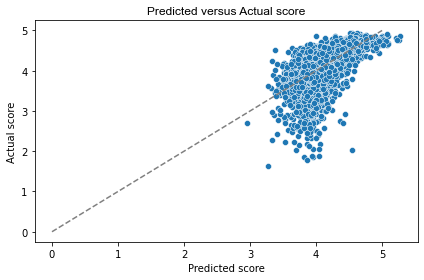

In [84]:
fig, ax = plt.subplots()
sns.scatterplot(y_pred_test, y_test)
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
ax.plot(np.linspace(0,5,5), np.linspace(0,5,5), ls="--", c="0.5")
plt.tight_layout()
plt.title('Predicted versus Actual score',family='arial',fontsize=12);
#plt.yticks(np.linspace(0,5,11), ['0','0.5','1.0','1.5','2.0','2.5','3.0','3.5','4.0','4.5','5.0'])
#plt.xticks(np.linspace(0,6,13), ['0','0.5','1.0','1.5','2.0','2.5','3.0','3.5','4.0','4.5','5.0','5.5','6.0'])
plt.tight_layout()
#plt.savefig('predictedactual_apps.svg');
plt.show;

Great! Model is no longer overfitting